In [1]:
# adapted from: 
# https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [2]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns

ICA steps to convergence:
1. Center x by subtracting the mean
2. Whiten x
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged (until W is orthogonal) and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals

In [3]:
# subt the mean from array: complexity O(n)
def center(x):
    x = np.array(x)
    # calculating mean along one axis: O(n)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

# Whitening a signal:

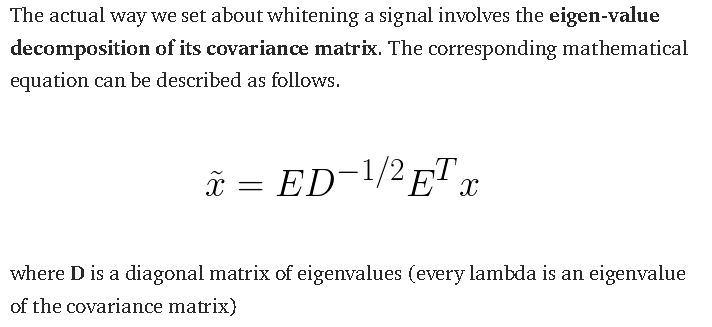

source: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [4]:
# To “whiten” a given signal means that we transform it in such a way that 
# potential correlations between its components are removed (covariance equal to 0) 
# and the variance of each component is equal to 1.

# complexity: O(N \times n^2) + O(n^3) + O(n) + O(n^3) + O(n^2) + O(n) = O(n^3)
def whitening(x):
    # complexity of np.cov: O(N \times n^2)
    # N as number of datapoints and n being the number of features, https://cstheory.stackexchange.com/questions/14734/what-is-computational-complexity-of-calculating-the-variance-covariance-matrix
    cov = np.cov(x) 
    # complexity of eigh: O(n^3), https://stackoverflow.com/questions/713878/how-expensive-is-it-to-compute-the-eigenvalues-of-a-matrix
    d, E = np.linalg.eigh(cov)
    # complexity of diag: O(n)
    D = np.diag(d)
    # complexity of matrix inv: O(n^3)
    # complexity of sqrt operation: O(n^2)
    D_inv = np.sqrt(np.linalg.inv(D))
    # complexity of dot product: O(n)
    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))
    return x_whiten

# Mathematically:

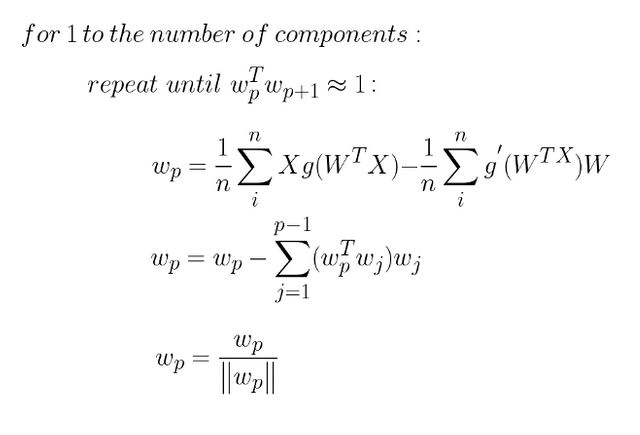

source: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [5]:
# g(x) in this algorithm is tanh(x):
# complexity: given 2x2 matrix: O(n^2)
def g(x):
    return np.tanh(x)

# g'(x) is derivative of g(x) = tanh(x) 
# complexity: given 2x2 matrix: O(n^2)
def g_dash(x):
    return 1 - g(x) * g(x)

In [6]:
# according to algorithm given in first cell
# complexity: O(n^2)
def calculate_new_w(w, X):
    # max complexity in this line: O(n^2) of multiplication
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_dash(np.dot(w.T, X)).mean() * w
    # max complexity: O(n^2)
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [7]:
# entire algorithm
def ica(X, n, iterations, tolerance=1e-5):
    X = center(X) # complexity O(n)
    X = whitening(X) # complexity O(n^3)
    components_nr = n
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    ds = [[] for i in range(components_nr)]
    
    for i in range(components_nr): # no of samples = N
        w = np.random.rand(components_nr)
        
        for j in range(iterations): # iterations = i
            w_new = calculate_new_w(w, X) # complexity O(N * f)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i]) # max. complexity O(n)
                
            distance = np.abs(np.abs((w * w_new).sum()) - 1) # max. complexity O(n^2)
            w = w_new
            ds[i].append(distance)
            if distance < tolerance: # convergence, best case b iterations
                break
        W[i, :] = w
        
    S = np.dot(W, X) # complexity O(n)
    
    plt.figure(figsize=(10,2))
    plt.title("Errors")
    for i in range(components_nr):
        plt.plot(np.array(ds[i]) + i)
    plt.legend(["First", "Sec", "Third"])
    plt.show()
    return S

In [8]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time)

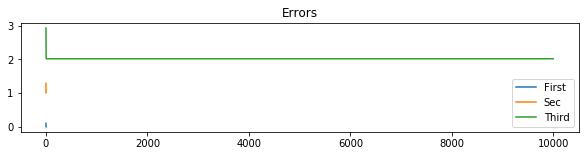

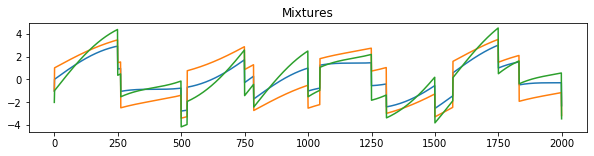

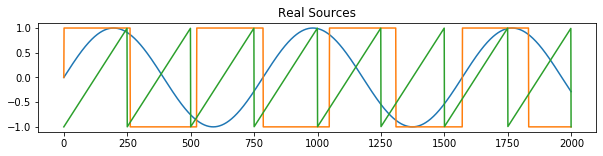

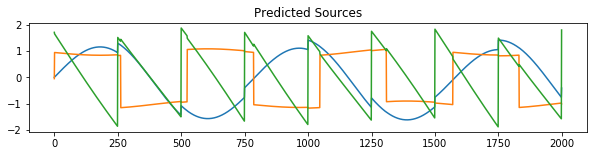

In [9]:
Xhat = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(Xhat, A.T)
X = X.T
S = ica(X, 3, iterations=10000, tolerance=0.01)

plt.figure(figsize=(10,2))
plt.title("Mixtures")
for i in range(len(X)):
    plt.plot(X[i])
    
plt.figure(figsize=(10,2))
plt.title("Real Sources")
a = [s1, s2, s3]
for i in range(len(a)):
    plt.plot(a[i])
    
plt.figure(figsize=(10,2))
plt.title("Predicted Sources")
for i in range(len(S)):
    plt.plot(S[i])

# Smush all the signals into one:

(3, 2000)
(2000,)


Text(0.5, 1.0, 'Squished')

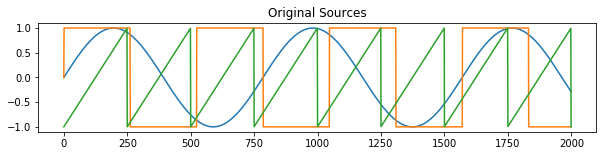

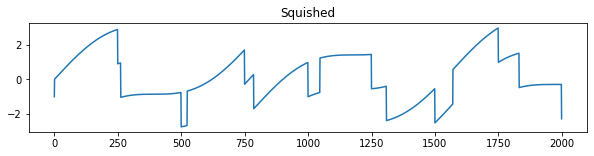

In [10]:
X = np.c_[s1, s2, s3]
X = X.T 
print(X.shape)

Y = np.sum(X, axis=0)
print(Y.shape)

plt.figure(figsize=(10,2))
plt.title("Original Sources")
for i in range(3):
    plt.plot(X[i])
    
plt.figure(figsize=(10,2))
plt.plot(Y)
plt.title("Squished")

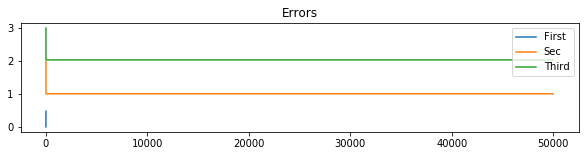

Text(0.5, 1.0, 'Squished Input')

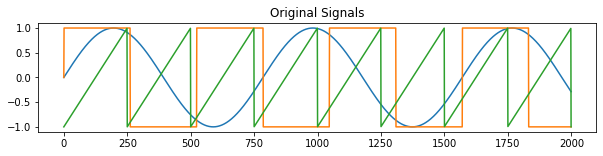

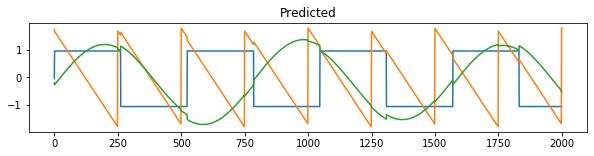

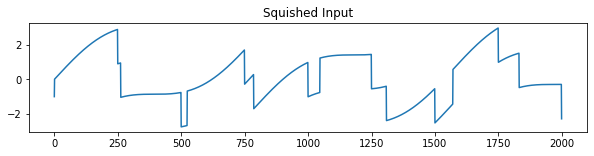

In [11]:
S = ica(X, 3, iterations=50000)

plt.figure(figsize=(10,2))
plt.title("Original Signals")
for i in range(3):
    plt.plot(X[i])

plt.figure(figsize=(10,2))
plt.title("Predicted")
for i in range(3):
    plt.plot(S[i])
    
plt.figure(figsize=(10,2))
plt.plot(Y)
plt.title("Squished Input")